# Sample analysis: Debt Yield Fall

## Overview

In this notebook, we walk through an example model from top to bottom. The notebook can be customized to predict any trigger category by modifying the "target" variable.

## Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
np.random.seed(99)
RANDOM_STATE = 99
# pd.set_option('display.max_rows', 151)
# pd.set_option('display.max_columns', 30)


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.utils import resample

import time
import pickle

import spacy
import en_core_web_lg
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en_core_web_lg', disable = 'parser')

import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)


## Import Data

In [2]:
# Import the CSV file
raw_df = pd.read_csv('../data/sasb_cash_trap_triggers_06_16_20.csv')
raw_df = raw_df.dropna(how='all')

In [3]:
# Review the first few rows of the data set
raw_df.head()

,Document,Sentence,Trigger,Multiclass
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",Loan Default,0
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Aggregate DSCR Fall,1
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Loan Default,1
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,Loan Default,0
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,Loan Default,0


In [4]:
# Check size of the data set
raw_df.shape

(2668, 4)

In [5]:
raw_df = raw_df[['Document', 'Sentence', 'Trigger', 'Multiclass']]

In [6]:
# Check for null values
raw_df.isnull().sum()

Document      0
Sentence      0
Trigger       0
Multiclass    0
dtype: int64

In [7]:
raw_df.dropna()
raw_df.shape

(2668, 4)

In [8]:
raw_df.head(11)

,Document,Sentence,Trigger,Multiclass
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",Loan Default,0
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Aggregate DSCR Fall,1
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Loan Default,1
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,Loan Default,0
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,Loan Default,0
5,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,Loan Default,0
6,20120828_01Y0R8_Prospectus_CM00000000205875087...,So long as no Trigger Period or Event of Defau...,Loan Default,0
7,20120828_01Y0R8_Prospectus_CM00000000205875087...,During the continuance of a Trigger Period or ...,Loan Default,0
8,20120828_01Y0R8_Prospectus_CM00000000205875087...,“Trigger Period” means any period that the deb...,DSCR Fall,0
9,20120828_01Y0R8_Prospectus_CM00000000205875087...,"During the continuance of a Trigger Period, th...",Loan Default,0


## Data Cleaning

In [9]:
# Review number of Trigger types
raw_df['Trigger'].value_counts()

nontrigger                   1056
Unspecified                   509
Loan Default                  493
Debt Yield Fall               172
Loan default                   75
Tenant Failure                 74
Mezzanine Default              68
Bankruptcy                     47
Debt yield fall                34
Renovations                    26
DSCR Fall                      24
Operator Termination           19
Sponsor Termination            14
Aggregate Debt Yield Fall      13
Mezzanine Outstanding          10
SFF                             9
Aggregate DSCR Fall             8
Mezzanine default               8
Aggregate debt yield fall       6
Delayed Repayment               3
Name: Trigger, dtype: int64

In [10]:
# Convert each category to Title format (to remove discrepancies based on capitalization)
raw_df['Trigger'] = raw_df['Trigger'].str.title()

In [11]:
raw_df['Trigger'] = raw_df['Trigger'].str.replace('Falll', 'Fall')

In [12]:
raw_df.loc[raw_df['Trigger'] == 'Aggregate Debt Yield', 'Trigger'] = 'Aggregate Debt Yield Fall'

In [13]:
raw_df['Sentence'] = raw_df['Sentence'].replace({'\$':''}, regex = True)

In [14]:
# Review clean Trigger Types
raw_df['Trigger'].value_counts()

Nontrigger                   1056
Loan Default                  568
Unspecified                   509
Debt Yield Fall               206
Mezzanine Default              76
Tenant Failure                 74
Bankruptcy                     47
Renovations                    26
Dscr Fall                      24
Operator Termination           19
Aggregate Debt Yield Fall      19
Sponsor Termination            14
Mezzanine Outstanding          10
Sff                             9
Aggregate Dscr Fall             8
Delayed Repayment               3
Name: Trigger, dtype: int64

In [15]:
# Rename first column (document title)
# raw_df = raw_df.rename(columns = {'0': 'Document'})

In [16]:
# Drop Multiclass column for now 
raw_df = raw_df.drop('Multiclass', axis = 1)


In [17]:
raw_df.shape

(2668, 3)

In [18]:
# Count the number of distinct documents
num_docs = raw_df['Document'].nunique()
print(f'{num_docs} unique documents have been included in the data set')

36 unique documents have been included in the data set


In [19]:
# Review the distinct documents and the number of Trigger events identified for each
raw_df['Document'].value_counts()

20181231_02IEP9_Prospectus_SD000000002568455603.pdf     176
20190220_02IPLU_Prospectus_SD000000002587491183.pdf     138
20190220_02IUQ7_Prospectus_SD000000002587520085.pdf     135
20160510_02B0XU_Prospectus_SD000000002312723382.pdf     125
20190108_02IFF1_Prospectus_SD000000002570458466.pdf     118
20190131_02IFCW_Prospectus_SD000000002578232050.pdf     114
20190131_02IFDN_Prospectus_SD000000002578234912.pdf     112
20190131_02IFE7_Prospectus_SD000000002578234792.pdf     111
20190208_02IM7M_Prospectus_SD000000002581684036.pdf     109
20190220_02IUQG_Prospectus_SD000000002587491537.pdf     100
20190205_02IJ77_Prospectus_SD000000002579874729.pdf      99
20170616_02DNAM_Prospectus_SD000000002355931744.pdf      84
20180125_02FE6L_Prospectus_SD000000002394837596.pdf      82
20170814_02E227_Prospectus_SD000000002367167139.pdf      82
20170525_02DG4Z_Prospectus_SD000000002352418696.pdf      76
20170727_02DTVX_Prospectus_SD000000002362015714.pdf      75
20170525_02DFUI_Prospectus_SD00000000235

In [20]:
# Summarize the trigger counts for the existing Document set
max_triggers = raw_df['Document'].value_counts().max()
min_triggers = raw_df['Document'].value_counts().min()
print(f'The {num_docs} Documents have tag counts that range from {min_triggers} to {max_triggers}.')

The 36 Documents have tag counts that range from 25 to 176.


In [21]:
raw_df.shape

(2668, 3)

In [22]:
raw_df.head()

,Document,Sentence,Trigger
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",Loan Default
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Aggregate Dscr Fall
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Loan Default
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,Loan Default
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,Loan Default


In [23]:
# Review new number of Trigger types
raw_df['Trigger'].value_counts()

Nontrigger                   1056
Loan Default                  568
Unspecified                   509
Debt Yield Fall               206
Mezzanine Default              76
Tenant Failure                 74
Bankruptcy                     47
Renovations                    26
Dscr Fall                      24
Operator Termination           19
Aggregate Debt Yield Fall      19
Sponsor Termination            14
Mezzanine Outstanding          10
Sff                             9
Aggregate Dscr Fall             8
Delayed Repayment               3
Name: Trigger, dtype: int64

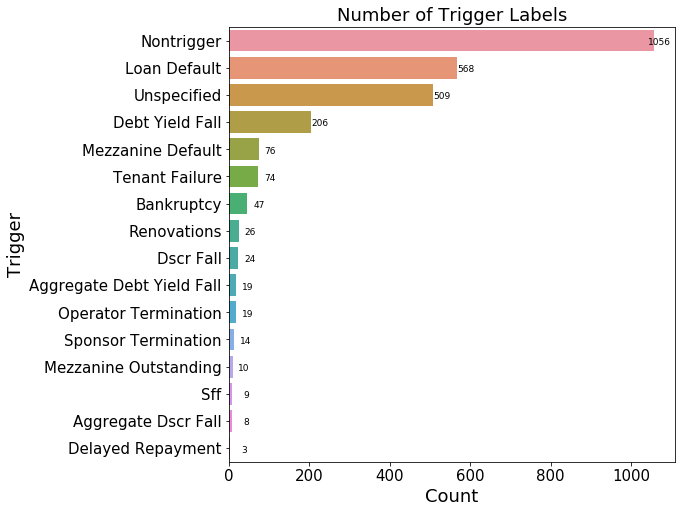

In [24]:
trigger_order = raw_df['Trigger'].value_counts().sort_values(ascending = False).index

fig = plt.gcf()
fig.set_size_inches(8, 8)
ax = sns.countplot(y=raw_df['Trigger'], data=raw_df, orient = 'h', order = trigger_order)
ax.set_title('Number of Trigger Labels', fontsize = 18)

plt.xlabel('Count', fontsize = 18)
plt.ylabel('Trigger', fontsize = 18)
plt.tick_params(labelsize=15)

for p in ax.patches:
    ax.annotate(int(p.get_width()),((p.get_x() + p.get_width()), p.get_y()), xytext=(17, -15),fontsize=9,textcoords='offset points', horizontalalignment='right')
    
#https://stackoverflow.com/questions/50190409/how-to-annotate-horizontal-seaborn-countplots

Note that at this stage, we haven't removed duplicate sentences within a document.

## Reshape the Data

In this section, we'll reshape the data, such that each sentence is represented once, with separate categorization columns for each Trigger type

In [25]:
# function to reshape the dataframe such that the triggers are 0/1 columns. Remove duplicates
def reshape_trigger_representation(dataframe):
    # select trigger types
    trigger_types = list(dataframe['Trigger'].unique())
    trigger_types = [x for x in trigger_types if str(x) != 'nan']
    
    # create new dataframe with unique document-sentence pairs (no duplicates)
    reshaped = dataframe.drop('Trigger', axis = 1).drop_duplicates().reset_index().drop('index', axis = 1)
    
    # select rows by trigger, reassign as 1 or 0 (for True or False)
    for tt in trigger_types:
        # select part that is trigger_type
        temp = dataframe.loc[dataframe['Trigger'] == tt].copy()

        # create a new column of true with trigger name
        temp[tt.lower().replace(' ', '_')] = np.int64(1)
        temp.drop('Trigger', axis=1, inplace=True)
        temp[tt.lower().replace(' ', '_')] = temp[tt.lower().replace(' ', '_')].astype('Int64')
        
        # left join this adjusted column to the unique data
        reshaped = reshaped.merge(temp, how='left', left_on=['Document', 'Sentence'], right_on=['Document', 'Sentence'])
        
        reshaped = reshaped.drop_duplicates().reset_index().drop('index', axis = 1)
        
    # replace nulls with False
    reshaped = reshaped.fillna(0)    
    
    return reshaped

In [26]:
# Reshape our original dataframe
df = reshape_trigger_representation(raw_df)

In [27]:
df.shape

(2280, 18)

In [28]:
df.head(5)

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff,delayed_repayment
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
df.shape

(2280, 18)

In [30]:
# Export reshaped to CSV file
# df.to_csv('../data/reshaped_06_09_20_dedupe.csv')

In [31]:
# Create a dataframe showing the document tagging details (removing sentence details)
doc_view = df.groupby('Document').sum()


In [32]:
doc_view['sum'] = doc_view.sum(axis = 1)
doc_view

,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff,delayed_repayment,sum
Document,,,,,,,,,,,,,,,,,
20120828_01Y0R8_Prospectus_CM000000002058750876.pdf,17,1,2,0,0,0,0,0,0,0,0,0,0,43,0,0,63.0
20150307_028S2X_Prospectus_SD000000002389024187.pdf,15,0,4,10,0,0,0,0,0,0,0,0,0,27,0,0,56.0
20160310_02AQCW_Prospectus_SD0000000-2003264558.pdf,7,0,0,6,5,3,2,2,0,0,0,0,0,0,0,0,25.0
20160510_02B0XU_Prospectus_SD000000002312723382.pdf,11,0,3,5,0,0,3,0,4,15,0,0,0,76,0,0,117.0
20170525_02DFUI_Prospectus_SD000000002352389122.pdf,12,0,7,6,0,0,4,0,4,0,0,0,0,29,0,0,62.0
20170525_02DG4Z_Prospectus_SD000000002352418696.pdf,18,0,0,8,7,0,0,0,0,0,2,0,0,33,0,0,68.0
20170616_02DNAM_Prospectus_SD000000002355931744.pdf,12,1,1,7,0,0,7,0,0,0,0,0,0,56,0,0,84.0
20170727_02DTVX_Prospectus_SD000000002362015714.pdf,19,0,0,8,2,0,0,0,0,0,0,0,0,40,0,0,69.0
20170801_02DX5C_Prospectus_SD000000002363000910.pdf,5,0,0,16,6,0,0,0,0,0,0,0,0,37,0,0,64.0


In [33]:
# Export reshaped to CSV file
# doc_view.to_csv('../data/exported_data/doc_view_06_09_20.csv')

In [34]:
# Isolate documents that don't have any Trigger tags (only nontriggers)
no_trigger_tags = list(doc_view.loc[doc_view['sum'] == doc_view['nontrigger']].index)
no_trigger_tags # Save document names to a list

[]

In [35]:
# we will remove any documents that have 0 Cash Trap Trigger clauses within the data set

to_remove = df[df['Document'].isin(no_trigger_tags)]
df = df.drop(to_remove.index)

In [36]:
df.shape

(2280, 18)

## Feature Engineering

In [37]:
# Create a column with length of Sentence
#df['sentence_char_count'] = df['Sentence'].str.len()

In [38]:
df['Sentence'].str.len().max()

8292

In [39]:
df.head()

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff,delayed_repayment
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Natural Language Processing of the sentence column

In [40]:
nlp = spacy.load('en_core_web_sm', disable = 'parser')

In [41]:
# Review a tokenized sample Sentence
[token.text for token in nlp(df['Sentence'][2])]

['During',
 'a',
 'Trigger',
 'Period',
 'or',
 'while',
 'an',
 'event',
 'of',
 'default',
 'under',
 'the',
 'Mortgage',
 'Loan',
 'is',
 'continuing',
 ',',
 'all',
 'amounts',
 'available',
 'in',
 'the',
 'Cash',
 'Management',
 'Account',
 'will',
 'be',
 'applied',
 'on',
 'each',
 'Loan',
 'Payment',
 'Date',
 'in',
 'the',
 'following',
 'order',
 'of',
 'priority',
 ':',
 '(',
 'i',
 ')',
 'to',
 'the',
 'Tax',
 'and',
 'Insurance',
 'Reserve',
 'Account',
 ',',
 '(',
 'a',
 ')',
 '1/12th',
 'of',
 'projected',
 'annual',
 'taxes',
 'and',
 '(',
 'b',
 ')',
 '1/12th',
 'of',
 'projected',
 'annual',
 'insurance',
 'premiums',
 '(',
 'unless',
 'certain',
 'blanket',
 'policies',
 'are',
 'in',
 'effect',
 ')',
 ',',
 '(',
 'ii',
 ')',
 'to',
 'the',
 'lender',
 ',',
 'the',
 'amount',
 'of',
 'all',
 'scheduled',
 'or',
 'delinquent',
 'interest',
 'and',
 'principal',
 'on',
 'the',
 'Mortgage',
 'Loan',
 'and',
 'all',
 'other',
 'amounts',
 'then',
 'due',
 'and',
 'payab

In [42]:
# Review a lemmatized sample Sentence
[token.lemma_ for token in nlp(df['Sentence'][2])]

['during',
 'a',
 'trigger',
 'period',
 'or',
 'while',
 'an',
 'event',
 'of',
 'default',
 'under',
 'the',
 'mortgage',
 'loan',
 'be',
 'continue',
 ',',
 'all',
 'amount',
 'available',
 'in',
 'the',
 'cash',
 'management',
 'account',
 'will',
 'be',
 'apply',
 'on',
 'each',
 'loan',
 'payment',
 'date',
 'in',
 'the',
 'follow',
 'order',
 'of',
 'priority',
 ':',
 '(',
 'i',
 ')',
 'to',
 'the',
 'tax',
 'and',
 'insurance',
 'reserve',
 'account',
 ',',
 '(',
 'a',
 ')',
 '1/12th',
 'of',
 'project',
 'annual',
 'tax',
 'and',
 '(',
 'b',
 ')',
 '1/12th',
 'of',
 'project',
 'annual',
 'insurance',
 'premium',
 '(',
 'unless',
 'certain',
 'blanket',
 'policy',
 'be',
 'in',
 'effect',
 ')',
 ',',
 '(',
 'ii',
 ')',
 'to',
 'the',
 'lender',
 ',',
 'the',
 'amount',
 'of',
 'all',
 'schedule',
 'or',
 'delinquent',
 'interest',
 'and',
 'principal',
 'on',
 'the',
 'mortgage',
 'loan',
 'and',
 'all',
 'other',
 'amount',
 'then',
 'due',
 'and',
 'payable',
 'under',
 'the

In [43]:
def tokenize(text):
    doc = nlp(text)
    tokens = [token.text for token in doc]
    return ' '.join(tokens)

df['SentenceTokens'] = df['Sentence'].apply(tokenize)

In [44]:
def lemmatize(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return ' '.join(lemmas)

df['SentenceLemmas'] = df['Sentence'].apply(lemmatize).str.replace("[^a-zA-Z0-9#']", " ").str.replace('\s{2,}', ' ')

In [45]:
df.head()

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff,delayed_repayment,SentenceTokens,SentenceLemmas
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"On each Business Day , the financial instituti...",on each business day the financial institution...
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,The Borrower has established and is required t...,the borrower have establish and be require to ...
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,During a Trigger Period or while an event of d...,during a trigger period or while an event of d...
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,On any Business Day all amounts on deposit in ...,on any business day all amount on deposit in t...
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Available funds in each Cash Management Accoun...,available fund in each cash management account...


In [46]:
# Put all sentences into a list of review tokens
all_sentence_tokens = ' '.join(df['SentenceTokens'])
all_sentence_tokens[:75]

'On each Business Day , the financial institution maintaining the blocked ac'

In [47]:
# Put all sentences into a list of review lemmas
all_sentence_lemmas = ' '.join(df['SentenceLemmas'])
all_sentence_lemmas[:75]

'on each business day the financial institution maintain the block account w'

In [48]:
sentence_token_list = [token for token in all_sentence_tokens.split(' ')]
sentence_lemma_list = [lemma for lemma in all_sentence_lemmas.split(' ')]

In [49]:
token_df = pd.Series(sentence_token_list)
lemma_df = pd.Series(sentence_lemma_list)

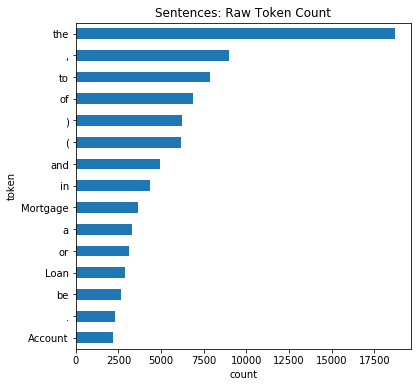

In [50]:
# Plotting the raw token count
token_series = token_df.value_counts().head(15).sort_values(ascending = True)
ax = token_series.plot.barh(figsize = (6,6))
ax.set_xlabel('count')
ax.set_ylabel('token')
ax.set_title('Sentences: Raw Token Count');

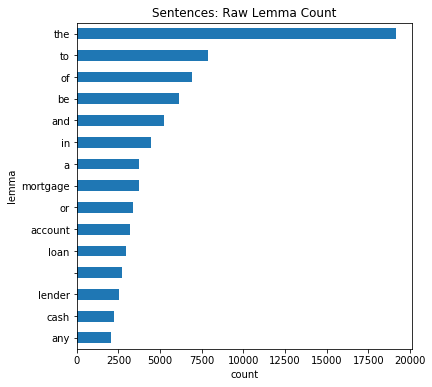

In [51]:
# Plotting the raw lemma count
lemma_series = lemma_df.value_counts().head(15).sort_values(ascending = True)
ax = lemma_series.plot.barh(figsize = (6,6))
ax.set_xlabel('count')
ax.set_ylabel('lemma')
ax.set_title('Sentences: Raw Lemma Count');

In [52]:
# Remove punctuation, maintain letters and numbers
df['SentenceLemmas_nopunc'] = df['SentenceLemmas'].str.replace("[^a-zA-Z0-9#']", " ")

In [53]:
# Put all SentenceLemmas_nopunc into a list
all_lemmas_nopunc = ' '.join(df['SentenceLemmas_nopunc'])
lemma_list_nopunc = [lemma for lemma in all_lemmas_nopunc.split(' ')]
lemma_list_nopunc = [lemma for lemma in lemma_list_nopunc if lemma not in ['']]
lemma_list_nopunc[:10]

['on',
 'each',
 'business',
 'day',
 'the',
 'financial',
 'institution',
 'maintain',
 'the',
 'block']

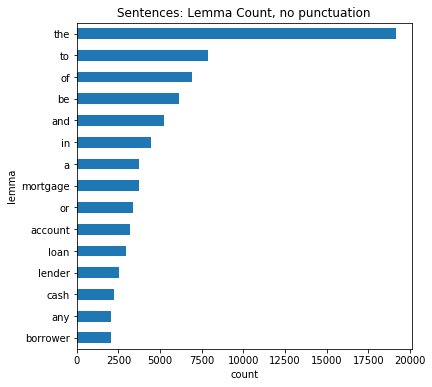

In [54]:
# Create a data series containing the list of words
lemma_df_nopunc = pd.Series(lemma_list_nopunc)
lemma_series_nopunc = lemma_df_nopunc.value_counts().head(15).sort_values(ascending = True)
ax = lemma_series_nopunc.plot.barh(figsize = (6,6))
ax.set_xlabel('count')
ax.set_ylabel('lemma')
ax.set_title('Sentences: Lemma Count, no punctuation');

In [55]:
df['SentenceLemmas_nopunc'].head()

0    on each business day the financial institution...
1    the borrower have establish and be require to ...
2    during a trigger period or while an event of d...
3    on any business day all amount on deposit in t...
4    available fund in each cash management account...
Name: SentenceLemmas_nopunc, dtype: object

In [56]:
df['SentenceLemmas_nopunc'] = df['SentenceLemmas_nopunc'].str.replace('\s{2,}', ' ')

In [57]:
df['SentenceLemmas_nopunc'].head()

0    on each business day the financial institution...
1    the borrower have establish and be require to ...
2    during a trigger period or while an event of d...
3    on any business day all amount on deposit in t...
4    available fund in each cash management account...
Name: SentenceLemmas_nopunc, dtype: object

## Preprocessing and Preparation for Modeling

In [58]:
short_stopwords = ['the', 'to', 'of', 'be', 'and', 'in', 'a', 'marriott']
short_stopwords2 = ['the', 'and', 'a', 'to', 'it', 'be', 'for', 'with', 'that', 'marriott']

In [59]:
# Look at original stopword list
stopwords = list(STOP_WORDS)
stopwords = stopwords + ['marriott']

## Train/Test Split

In [60]:
df.head()

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,...,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff,delayed_repayment,SentenceTokens,SentenceLemmas,SentenceLemmas_nopunc
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"On each Business Day , the financial instituti...",on each business day the financial institution...,on each business day the financial institution...
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,The Borrower has established and is required t...,the borrower have establish and be require to ...,the borrower have establish and be require to ...
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,During a Trigger Period or while an event of d...,during a trigger period or while an event of d...,during a trigger period or while an event of d...
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,On any Business Day all amounts on deposit in ...,on any business day all amount on deposit in t...,on any business day all amount on deposit in t...
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Available funds in each Cash Management Accoun...,available fund in each cash management account...,available fund in each cash management account...


In [61]:
# Start by predicting Loan Default trigger

target = 'debt_yield_fall'


X = df['SentenceLemmas']
y = df[target]
indices = df.index

y = y.astype('int')

In [62]:
y.dtypes

dtype('int64')

In [63]:
# Checking shape of X and y 
print(f'X shape is {X.shape}')
print(f'y shape is {y.shape}')

X shape is (2280,)
y shape is (2280,)


In [64]:
y.value_counts()

0    2092
1     188
Name: debt_yield_fall, dtype: int64

In [65]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size = 0.3, stratify = y, random_state = RANDOM_STATE)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(indices_train.shape, indices_test.shape)

(1596,) (1596,)
(684,) (684,)
(1596,) (684,)


In [66]:
X.head()

0    on each business day the financial institution...
1    the borrower have establish and be require to ...
2    during a trigger period or while an event of d...
3    on any business day all amount on deposit in t...
4    available fund in each cash management account...
Name: SentenceLemmas, dtype: object

In [67]:
X_train.shape[0]

1596

In [68]:
y_train.shape[0]

1596

## Modeling

### CountVectorizer + Logistic Regression GridSearch and modeling

In [69]:
# Define CVEC + Logistic Regression Pipeline
pipe_cvec = Pipeline([('cvec', CountVectorizer()), ('lr', LogisticRegression(solver = 'liblinear', random_state = RANDOM_STATE))])
cvec_params = {
    'cvec__ngram_range': [(1,2), (1,3), (1,4), (1,5), (1,6), (1,7), (1,8)],
    'cvec__stop_words': [None, short_stopwords, short_stopwords2, stopwords],  
    'cvec__max_features': [100, 200, 400, 600, 1000],
    'cvec__min_df': [2],
    'cvec__max_df': [.99],
    }

gs_cvec = GridSearchCV(pipe_cvec, param_grid = cvec_params, cv = 3, scoring = 'roc_auc')

# Start the timer.
t0 = time.time()

results_cvec = gs_cvec.fit(X_train, y_train)

print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.



Seconds elapsed for fitting: 316.792


In [70]:
t0 = time.time()
print(f'Training score is {results_cvec.score(X_train, y_train):.3f}')
print(f'Test score is {results_cvec.score(X_test, y_test):.3f}')
print(f'Cross Validation score is {cross_val_score(results_cvec.best_estimator_, X, y, cv = 3).mean():.3f}')
print(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.

Training score is 1.000
Test score is 0.998
Cross Validation score is 0.975
Seconds elapsed for score calculation: 1.070


In [71]:
print(f'Best Score:{(results_cvec.best_score_):.3f}')
print(f'Best Parameters :{results_cvec.best_params_}')

Best Score:0.976
Best Parameters :{'cvec__max_df': 0.99, 'cvec__max_features': 600, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': ['else', 'out', 'thence', 'top', 'a', 'along', 'see', 'with', 'since', 'therefore', 'too', 'her', 'upon', 'its', 'up', 'cannot', 'four', 'ten', 'keep', 'whether', 'without', 'last', 'namely', 'go', 'perhaps', 'twenty', 'anyhow', 'least', 'most', 'sometimes', 'whither', 'who', 'often', 'yourself', 'doing', 'rather', 'itself', 'were', 'next', 'own', 'beyond', 'three', 'former', 'wherein', 'someone', 'be', 'hundred', 'once', 'several', 'six', 'whenever', 'beside', 'except', 'could', 'through', 'seem', 'hereafter', 'how', 'any', 'thereby', 'whence', 'eight', 'are', 'those', 'done', 'full', 'yourselves', 'by', 'various', 'against', 'same', 'ever', 'should', 'per', 'unless', 'due', 'afterwards', 'already', 'serious', 'why', 'you', 'whole', 'the', 'alone', 'was', 'an', 'hereupon', 'herself', 'third', 'wherever', 'then', 'down', 'five', 'under'

### CountVectorizor + Random Forest

In [72]:

# Define CVEC + Logistic Regression Pipeline
pipe_rf = Pipeline([('cvec', CountVectorizer()), ('rf', RandomForestClassifier(random_state = RANDOM_STATE, n_jobs = 2))])
rf_params = {
    'cvec__ngram_range': [(1,2), (1,3), (1,4), (1,5)],
    'cvec__stop_words': [short_stopwords, short_stopwords2],  
    'cvec__max_features': [100, 200, 400, 800],
    'cvec__min_df': [2],
    'cvec__max_df': [.99],
    'rf__max_depth': [4,5, 6],
    'rf__min_samples_split': [2,3],
    'rf__min_samples_leaf': [10, 12]
    }

gs_rf = GridSearchCV(pipe_rf, param_grid = rf_params, cv = 3, scoring = 'roc_auc')

# Start the timer.
t0 = time.time()

results_rf = gs_rf.fit(X_train, y_train)

print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.



Seconds elapsed for fitting: 877.889


In [73]:

t0 = time.time()
print(f'Training score is {results_rf.score(X_train, y_train):.3f}')
print(f'Test score is {results_rf.score(X_test, y_test):.3f}')
print(f'Cross Validation score is {cross_val_score(results_rf.best_estimator_, X, y, cv = 3).mean():.3f}')
print(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.


Training score is 0.999
Test score is 0.996
Cross Validation score is 0.958
Seconds elapsed for score calculation: 4.105


In [74]:

print(f'Best Score: {results_rf.best_score_}')
print(f'Best Parameters: {results_rf.best_params_}')


Best Score: 0.9984165424739196
Best Parameters: {'cvec__max_df': 0.99, 'cvec__max_features': 800, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 4), 'cvec__stop_words': ['the', 'and', 'a', 'to', 'it', 'be', 'for', 'with', 'that', 'marriott'], 'rf__max_depth': 5, 'rf__min_samples_leaf': 10, 'rf__min_samples_split': 2}


## Model Selection
- In this section we compare the Train and Test scores across the various models

In [75]:
# Check Training Scores across all models
print(f'Baseline Score:                                {y_test.value_counts(normalize=True)[0]:.3f}')
print(f'CountVectorizer + LogisticRegression Accuracy: {results_cvec.score(X_train, y_train):.3f}')
# print(f'TfidfVectorizer + LogisticRegression Accuracy: {results_tfidf.score(X_train, y_train):.3f}')
# print(f'CountVectorizer + Multinomial Naive Bayes:     {results_mnb.score(X_train, y_train):.3f}')
# print(f'TfidfVectorizer + Gaussian Naive Bayes:        {results_gnb.score(X_train, y_train):.3f}')
print(f'CountVectorizer + Random Forest Accuracy:      {results_rf.score(X_train, y_train):.3f}')

Baseline Score:                                0.918
CountVectorizer + LogisticRegression Accuracy: 1.000
CountVectorizer + Random Forest Accuracy:      0.999


In [76]:
# Check Testing Scores across all models
print(f'Baseline Score:                                {y_test.value_counts(normalize=True)[0]:.3f}')
print(f'CountVectorizer + LogisticRegression Accuracy: {results_cvec.score(X_test, y_test):.3f}')
# print(f'TfidfVectorizer + LogisticRegression Accuracy: {results_tfidf.score(X_test, y_test):.3f}')
# print(f'CountVectorizer + Multinomial Naive Bayes:     {results_mnb.score(X_test, y_test):.3f}')
# print(f'TfidfVectorizer + Gaussian Naive Bayes:        {results_gnb.score(X_test, y_test):.3f}')
print(f'CountVectorizer + Random Forest Accuracy:      {results_rf.score(X_test, y_test):.3f}')

Baseline Score:                                0.918
CountVectorizer + LogisticRegression Accuracy: 0.998
CountVectorizer + Random Forest Accuracy:      0.996


## Model Evaluation - Logistic Regression

In [77]:
# Isolate the individual words and their coefficients
# Feature names (i.e., words in the Sentences):
names = results_cvec.best_estimator_.steps[0][1].get_feature_names()

# classifier (betas):
classifier = results_cvec.best_estimator_.named_steps['lr']

# https://stackoverflow.com/questions/43856280/return-coefficients-from-pipeline-object-in-sklearn

In [78]:
# Extract coefficients from the classifier defined above
coef_cvec = np.array(classifier.coef_).tolist()[0]
coef_cvec[:10] #Look at 10 coefficients

[0.8166694036141269,
 -0.4207526071528033,
 0.07055011758656808,
 0.15000012399003096,
 0.16023180830563438,
 -0.07824300815319932,
 -0.052678710923049384,
 0.0022236207969580954,
 -0.051031750937031536,
 0.1667128520836647]

In [79]:
# Create zipped list of the word names with their corresponding beta coefficients
cvec_top_words = list(zip(names, coef_cvec))

In [80]:
# Create final dataframe of words with their corresponding coefficients
df_cvec_coefs = pd.DataFrame(cvec_top_words).rename(columns = {0: 'word', 1: 'coef'}).sort_values(by = 'coef', ascending = True)

In [81]:
# Top differentiating words and phrases for this Trigger type
df_cvec_coefs.tail(20).sort_values('coef', ascending = False)

,word,coef
323,low,1.200052
599,yield trigger,1.139003
152,debt yield,1.098479
598,yield,1.098479
324,low cash,0.921325
234,flow period,0.919493
0,00,0.816669
210,exceed,0.529227
135,cost,0.512332
232,flow,0.484478


In [82]:
# Display top opposing words and phrases for this Trigger type
df_cvec_coefs.head(20)

,word,coef
575,total,-1.012060
39,aggregate,-0.792106
345,minimum,-0.702361
16,account,-0.568134
574,time,-0.554214
296,lender,-0.551090
394,payment,-0.548706
327,management,-0.475225
481,require,-0.467392
309,loan,-0.462833


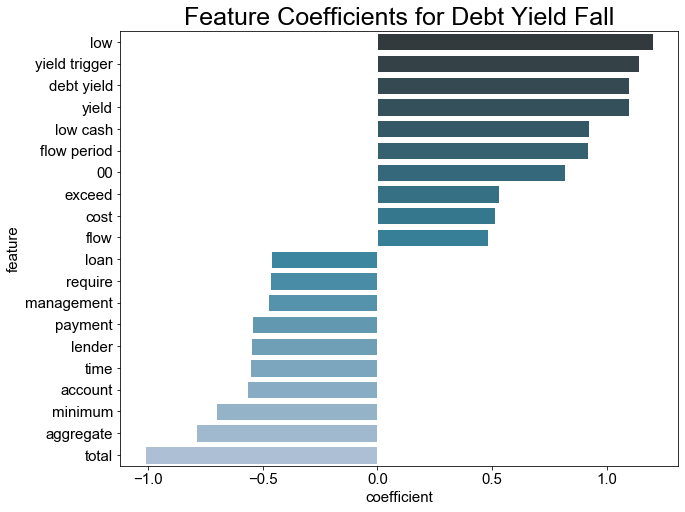

In [83]:
def coef_plot(category):
    '''
    Plots the top 10 and bottom 10 coefficients for the complexity category specified
    '''
    coefs_1 = df_cvec_coefs.sort_values(by=category, ascending=False).tail(10) # getting the top 10 coefficients
    coefs_2 = df_cvec_coefs.sort_values(by=category, ascending=False).head(10) # getting the bottom 10 coefficients
    coefs = pd.concat([coefs_2, coefs_1], axis = 0) # merging the two into one
    # plotting importance
    plt.figure(figsize=(10, 8)) # plotting the coefficients
    plt.title(f'Feature Coefficients for {target.replace("_", " ").title()}', fontsize=25)
    sns.set_style("darkgrid")
    sns.barplot(data=coefs,
                x=category,
                y='word',
                orient='h',
                palette = 'PuBuGn_d')
    plt.xlabel('coefficient', fontsize=15)
    plt.ylabel('feature', fontsize=15)
    plt.tick_params(labelsize=15)
coef_plot('coef')

## Calculating predictions and Confusion Matrix

In [84]:
# Here, we isolate our best model & make predictions based on our test data
best_model = results_cvec.best_estimator_
preds = best_model.predict(X_test)

In [85]:
# Checking our predictions
preds[:10]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [86]:
## Create a confusion matrix
from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(y_test, preds)
print('This is a confusion matrix for our test data vs predictions:')
print(cm_test)

This is a confusion matrix for our test data vs predictions:
[[625   3]
 [  5  51]]


In [87]:
# Converting our confusion matrix into a dataframe
cm_test = pd.DataFrame(cm_test, columns=['Predicted Negative','Predicted Positive'], 
                       index=['Actual Negative','Actual Positive'])

In [88]:
cm_test

,Predicted Negative,Predicted Positive
Actual Negative,625,3
Actual Positive,5,51


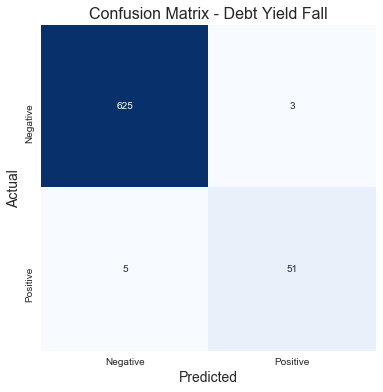

In [89]:
# Plot our confusion matrix
plt.figure(figsize = (6,6))
ax = plt.subplot()
sns.heatmap(cm_test, 
            annot=True, 
            ax = ax, 
            fmt='g', 
            cbar=False,
            cmap="Blues"); #annot=True to annotate cells

# labels, title and ticks
ax.set_title(f'Confusion Matrix - {target.replace("_", " ").title()}', size=16)
ax.set_xlabel('Predicted', size=14)
ax.set_ylabel('Actual', size=14)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive']);

In [90]:
# Setting up probabilities for the ROC curve
pred_proba = results_cvec.predict_proba(X_test)
preds = results_cvec.predict(X_test)



In [91]:
# Calculate probabilities
pred_proba = [i[1] for i in results_cvec.predict_proba(X_test)]
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
pred_df.shape

(684, 2)

In [92]:
# We establish the probabilities to be used to create the ROC curve
y_pred_proba = results_cvec.predict_proba(X_test)

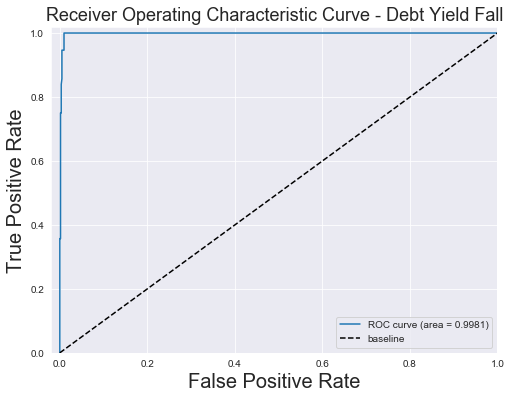

In [93]:
fpr, tpr, _= roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure(figsize = (8,6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='baseline')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate', fontsize =20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.title(f'Receiver Operating Characteristic Curve - {target.replace("_", " ").title()}', fontsize=18)
plt.legend(loc="lower right");

In [94]:
# To allow us to better read the Sentences
pd.set_option('display.max_colwidth', None)

In [95]:
result_cols = ['index', 'prediction', 'actual', 'model_input']
results = pd.DataFrame({'index': list(indices_test),'prediction': list(preds), 'actual': list(y_test), 'model_input': list(X_test)})

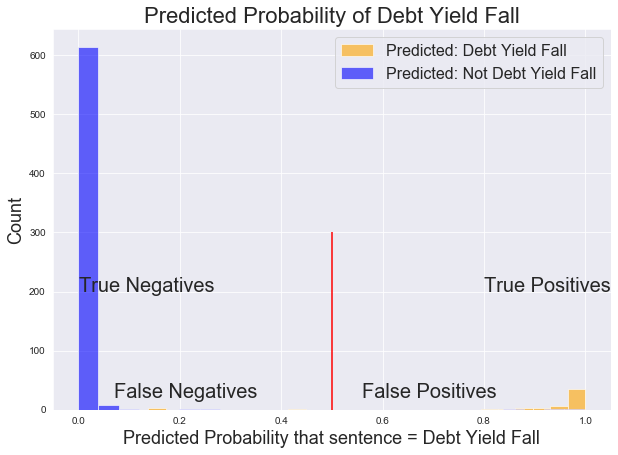

In [96]:
# Histogram overlay for two classes
plt.figure(figsize = (10,7))

# Create two histograms of observations.

plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins = 25,
         color = 'orange',
         alpha = 0.6,
         label = f'Predicted: {target.replace("_", " ").title()}')
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins = 25,
         color = 'b',
         alpha = 0.6,
         label = f'Predicted: Not {target.replace("_", " ").title()}')


plt.vlines(x = .5,
           ymin = 0,
           ymax = 300,
           color = 'r',
           linestyle = '-')


# Label axes.
plt.title(f'Predicted Probability of {target.replace("_", " ").title()}', fontsize = 22)
plt.ylabel('Count', fontsize = 18)
plt.xlabel(f'Predicted Probability that sentence = {target.replace("_", " ").title()}', fontsize = 18)

plt.annotate(xy = (0.001, 200), s = 'True Negatives', size = 20)
plt.annotate(xy = (0.07, 20), s = 'False Negatives', size = 20)
plt.annotate(xy = (0.56, 20), s = 'False Positives', size = 20)
plt.annotate(xy = (0.8, 200), s = 'True Positives', size = 20)

# Create legend.
plt.legend(fontsize = 16);

In [97]:
# set index as index column
results.set_index('index', inplace = True)
results.head()

,prediction,actual,model_input
index,,,
2202,0,0,under the term of the mortgage loan documents during a cash trap period the borrowers be require to maintain a reserve fund the ground lease reserve fund for the payment of ground rent with respect to the related property
1285,0,0,on the origination date borrower deposit with mortgage lender 573 275 into the environmental work reserve a contest real estate tax reserve the contested real estate tax reserve which represent the aggregate amount of the real estate tax for the 2015 2016 and 2017 calendar year such tax the contested tax that be be contest by borrower as of the origination date
1701,0,0,manager reserve account mean the eligible account maintain by the manager or an approved replacement manager under the management agreement or an approved replacement management agreement in the name of or for the benefit of the borrower in accordance with the term of the management agreement or the approved replacement management agreement
183,0,0,as the mortgage loan agreement do not require that any cash management account be establish prior to the first occurrence of a trigger period during the term of the mortgage loan there be a risk that the borrowers or the property manager could divert such fund as unless a trigger period exist fund in the restricted account be to be remit to the borrowers and be not require to be transfer to the cash management account
599,0,0,thus so long as a trigger period be not in effect the mortgage lender s control over revenue from the operation of the properties may be limit to the extent that revenue from the properties be transfer to or at the direction of the borrower as oppose to be pay to the cash management account as there be a risk that the borrower or the property manager could divert such fund for purpose unrelated to the properties


In [98]:
misclassified = results[results['prediction'] != results['actual']]


In [99]:
misclassified = misclassified.merge(df, how = 'left', left_index = True, right_index = True)

In [100]:
misclassified = misclassified[['prediction', 'actual', 'model_input', 'Document', 'Sentence',
       'loan_default', 'aggregate_dscr_fall', 'dscr_fall', 'unspecified',
       'debt_yield_fall', 'aggregate_debt_yield_fall', 'mezzanine_default',
       'tenant_failure', 'mezzanine_outstanding', 'operator_termination',
       'bankruptcy', 'sponsor_termination', 'renovations', 'nontrigger', 'sff']]

In [101]:
misclassified.head()

,prediction,actual,model_input,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff
index,,,,,,,,,,,,,,,,,,,,
564,1,0,trigger period mean a period a commence upon the early of i the occurrence and continuance of a mortgage loan event of default ii the receipt by mortgage lender of write notice from any mezzanine lenders that a mezzanine loan default other than as the result of the occurrence of a mortgage loan event of default have occur or iii the aggregate debt yield fall below the minimum debt yield and b expire upon x with regard to any trigger period commence in connection with clause a i above the curing of such mortgage loan event of default y with regard to any trigger period commence in connection with clause a ii above the applicable mezzanine lenders have deliver to mortgage lender write notice that such mezzanine loan default have be cure or waive and no other mezzanine loan default be then continue and z with regard to any trigger period commence in connection with clause a iii above the date that the aggregate debt yield be equal to or great than the minimum debt yield for two 2 consecutive calendar quarter,20190205_02IJ77_Prospectus_SD000000002579874729.pdf,"“Trigger Period” means a period: (A) commencing upon the earliest of: (i) the occurrence and continuance of a Mortgage Loan Event of Default; (ii) the receipt by Mortgage Lender of written notice from any Mezzanine Lenders that a Mezzanine Loan Default (other than as the result of the occurrence of a Mortgage Loan Event of Default) has occurred; or (iii) the Aggregate Debt Yield falling below the Minimum Debt Yield; and (B) expiring upon: (x) with regard to any Trigger Period commenced in connection with clause (A)(i) above, the curing of such Mortgage Loan Event of Default; (y) with regard to any Trigger Period commenced in connection with clause (A)(ii) above, the applicable Mezzanine Lenders has delivered to Mortgage Lender written notice that such Mezzanine Loan Default has been cured or waived (and no other Mezzanine Loan Default is then continuing); and (z) with regard to any Trigger Period commenced in connection with clause (A)(iii) above, the date that the Aggregate Debt Yield is equal to or greater than the Minimum Debt Yield for two (2) consecutive calendar quarters.",1,0,0,0,0,1,1,0,0,0,0,0,0,0,0
1977,0,1,loan features structure the mortgage loan be structure with hard lockbox and in place cash management as well as cash flow sweep if the mortgaged portfolio noi debt yield fall below 10 0,20190404_02J69Q_Prospectus_SD000000002615291894.pdf,Loan Features/Structure: The Mortgage Loan is structured with hard lockboxes and in-place cash management as well as cash flow sweeps if the Mortgaged Portfolio NOI debt yield falls below 10.0%.,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
317,0,1,trigger period define further herein to be establish upon i the occurrence and continuance of a mortgage loan event of default ii the debt yield fall below 8 75 iii any bankruptcy action with respect to the borrower or manager that have not be discharge or dismiss within 30 day of the occurrence thereof or iv the borrower s failure to deliver any require financial item within 10 business day after write notice from the lender,20181231_02IEP9_Prospectus_SD000000002568455603.pdf,"Trigger Period (defined further herein) to be established upon (i) the occurrence and continuance of a Mortgage Loan event of default, (ii) the debt yield falling below 8.75%, (iii) any bankruptcy action with respect to the Borrower or manager that has not been discharged or dismissed within 30 days of the occurrence thereof, or (iv) the Borrower’s failure to deliver any required financial item within 10 business days after written notice from the Lender.",1,0,0,0,1,0,0,0,0,0,1,0,0,0,0
637,0,1,cash management trigger

In [102]:
# misclassified['prediction'].astype('Int64')
# misclassified['actual'].astype('Int64')

In [103]:
print(f'We incorrectly predicted the trigger type for {misclassified.shape[0]} sentences.')

We incorrectly predicted the trigger type for 8 sentences.


In [104]:
# Show the split of the misclassified predictions
misclassified['prediction'].value_counts()

0    5
1    3
Name: prediction, dtype: int64

## Review the Incorrect Predictions

### Misclassifications: wrongly predicted to be the trigger category

In [105]:
misclassified_as_true = misclassified.loc[misclassified['prediction'] == 1]
misclassified_as_true

,prediction,actual,model_input,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff
index,,,,,,,,,,,,,,,,,,,,
564,1,0,trigger period mean a period a commence upon the early of i the occurrence and continuance of a mortgage loan event of default ii the receipt by mortgage lender of write notice from any mezzanine lenders that a mezzanine loan default other than as the result of the occurrence of a mortgage loan event of default have occur or iii the aggregate debt yield fall below the minimum debt yield and b expire upon x with regard to any trigger period commence in connection with clause a i above the curing of such mortgage loan event of default y with regard to any trigger period commence in connection with clause a ii above the applicable mezzanine lenders have deliver to mortgage lender write notice that such mezzanine loan default have be cure or waive and no other mezzanine loan default be then continue and z with regard to any trigger period commence in connection with clause a iii above the date that the aggregate debt yield be equal to or great than the minimum debt yield for two 2 consecutive calendar quarter,20190205_02IJ77_Prospectus_SD000000002579874729.pdf,"“Trigger Period” means a period: (A) commencing upon the earliest of: (i) the occurrence and continuance of a Mortgage Loan Event of Default; (ii) the receipt by Mortgage Lender of written notice from any Mezzanine Lenders that a Mezzanine Loan Default (other than as the result of the occurrence of a Mortgage Loan Event of Default) has occurred; or (iii) the Aggregate Debt Yield falling below the Minimum Debt Yield; and (B) expiring upon: (x) with regard to any Trigger Period commenced in connection with clause (A)(i) above, the curing of such Mortgage Loan Event of Default; (y) with regard to any Trigger Period commenced in connection with clause (A)(ii) above, the applicable Mezzanine Lenders has delivered to Mortgage Lender written notice that such Mezzanine Loan Default has been cured or waived (and no other Mezzanine Loan Default is then continuing); and (z) with regard to any Trigger Period commenced in connection with clause (A)(iii) above, the date that the Aggregate Debt Yield is equal to or greater than the Minimum Debt Yield for two (2) consecutive calendar quarters.",1,0,0,0,0,1,1,0,0,0,0,0,0,0,0
620,1,0,during a trigger period so long as no mortgage loan event of default have occur and be continue upon write request of the borrower the mortgage lender will disburse within three business days of the borrower s request but no more frequently than monthly excess cash flow funds for the following to the extent not previously pay from fund in the cash management account i debt service and mezzanine debt service ii payment of shortfall in the require deposit into the reserve accounts in each case to the extent require in the mortgage loan agreement or the mezzanine loan agreement iii voluntary prepayment of a the mortgage loan or b the mortgage loan and the mezzanine loan in accordance with the term of the mortgage loan agreement and the mezzanine loan agreement as applicable but only to the extent that such prepayment fully cure any low cash flow period iv payment of any document operating expenses and capital expenditures with respect any individual property include without limitation expense or shortfall relate to a restoration non controllable expense management fee interest rate cap cost leasing cost include all tenant improvement obligation leasing commission and tenant concession and sale use occupancy and similar tax on receipt v disbursement to the borrower to be distribute to PRON equity holder in an amount sufficient as reasonably determine by the borrower to enable the borrower or PRON direct or indirect equity holder to satisfy the distribution r

In [106]:
misclassified_as_true_summary = misclassified_as_true[['prediction', 'actual', 'loan_default', 'aggregate_dscr_fall', 'dscr_fall', 'unspecified',
       'debt_yield_fall', 'aggregate_debt_yield_fall', 'mezzanine_default',
       'tenant_failure', 'mezzanine_outstanding', 'operator_termination',
       'bankruptcy', 'sponsor_termination', 'renovations', 'nontrigger', 'sff']]


In [107]:
misclassified_as_true_count = misclassified_as_true_summary.shape[0]
print(f'{misclassified_as_true_count} sentences were predicted to be the trigger category, but in fact were not this category.')

3 sentences were predicted to be the trigger category, but in fact were not this category.


In [108]:
misclassified_as_true_summary.loc['sum',:] = misclassified_as_true.sum(axis = 0).copy(deep = True)


/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [109]:
misclassified_as_true_summary

,prediction,actual,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff
index,,,,,,,,,,,,,,,,,
564,1.0,0.0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0
620,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
326,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
sum,3.0,0.0,3,0,0,0,0,1,1,0,0,0,0,0,0,0,0


### Misclassifications: wrongly predicted NOT to be the trigger category

In [110]:
misclassified_as_false = misclassified.loc[misclassified['prediction'] == 0]
misclassified_as_false

,prediction,actual,model_input,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff
index,,,,,,,,,,,,,,,,,,,,
1977,0,1,loan features structure the mortgage loan be structure with hard lockbox and in place cash management as well as cash flow sweep if the mortgaged portfolio noi debt yield fall below 10 0,20190404_02J69Q_Prospectus_SD000000002615291894.pdf,Loan Features/Structure: The Mortgage Loan is structured with hard lockboxes and in-place cash management as well as cash flow sweeps if the Mortgaged Portfolio NOI debt yield falls below 10.0%.,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
317,0,1,trigger period define further herein to be establish upon i the occurrence and continuance of a mortgage loan event of default ii the debt yield fall below 8 75 iii any bankruptcy action with respect to the borrower or manager that have not be discharge or dismiss within 30 day of the occurrence thereof or iv the borrower s failure to deliver any require financial item within 10 business day after write notice from the lender,20181231_02IEP9_Prospectus_SD000000002568455603.pdf,"Trigger Period (defined further herein) to be established upon (i) the occurrence and continuance of a Mortgage Loan event of default, (ii) the debt yield falling below 8.75%, (iii) any bankruptcy action with respect to the Borrower or manager that has not been discharged or dismissed within 30 days of the occurrence thereof, or (iv) the Borrower’s failure to deliver any required financial item within 10 business days after written notice from the Lender.",1,0,0,0,1,0,0,0,0,0,1,0,0,0,0
637,0,1,cash management trigger i the occurrence of a mortgage loan or mezzanine loan event of default ii the debt yield include both the mortgage and mezzanine loan be less than a 6 25 for two consecutive quarter with respect to the initial term and the first three extension term and b 7 00 for two consecutive quarter with respect to the fourth and fifth extension,20190208_02IM7M_Prospectus_SD000000002581684036.pdf,"Cash Management Trigger (i) the occurrence of a mortgage loan or mezzanine loan event of default; (ii) the debt yield, including both the mortgage and mezzanine loans, being less than (a) 6.25% for two consecutive quarters with respect to the initial term and the first three extension terms and (b) 7.00% for two consecutive quarters with respect to the fourth and fifth extension",1,0,0,0,1,0,1,0,0,0,0,0,0,0,0
316,0,1,the mortgage loan be structure with a hard lock box with spring cash management upon the occurrence of a mortgage loan event of default or if the debt yield fall below 8 75 in any quarter,20181231_02IEP9_Prospectus_SD000000002568455603.pdf,The Mortgage Loan is structured with a hard lock box with springing cash management upon the occurrence of a Mortgage Loan event of default or if the debt yield falls below 8.75% in any quarter.,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
191,0,1,pool a minimum debt yield mean a debt yield of 8 86,20170801_02DX5C_Prospectus_SD000000002363000910.pdf,“Pool A Minimum Debt Yield” means a Debt Yield of 8.86%.,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [111]:
misclassified_as_false_summary = misclassified_as_false[['prediction', 'actual', 'loan_default', 'aggregate_dscr_fall', 'dscr_fall', 'unspecified',
       'debt_yield_fall', 'aggregate_debt_yield_fall', 'mezzanine_default',
       'tenant_failure', 'mezzanine_outstanding', 'operator_termination',
       'bankruptcy', 'sponsor_termination', 'renovations', 'nontrigger', 'sff']]


In [112]:
misclassified_as_false_count = misclassified_as_false.shape[0]
print(f'{misclassified_as_false_count} sentences were predicted not to be the trigger category, but in fact were this trigger category.')

5 sentences were predicted not to be the trigger category, but in fact were this trigger category.


In [113]:
misclassified_as_false_summary.loc['sum',:] = misclassified_as_false.sum(axis = 0).copy(deep = True)
misclassified_as_false_summary

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,prediction,actual,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff
index,,,,,,,,,,,,,,,,,
1977,0.0,1.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
317,0.0,1.0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0
637,0.0,1.0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0
316,0.0,1.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
191,0.0,1.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
sum,0.0,5.0,3,0,0,0,5,0,1,0,0,0,1,0,0,0,0


### Export Misclassification summaries

In [114]:
# Export to CSV file
#misclassified_as_false_summary.to_csv(f'../data/exported_data/{target}_misclassified_as_false_06_16_20.csv')
#misclassified_as_true_summary.to_csv(f'../data/exported_data/{target}_misclassified_as_true_06_16_20.csv')

In [115]:
# Export to CSV file
#misclassified_as_false.to_csv(f'../data/exported_data/{target}_misclassified_as_false_sentences_06_16_20.csv')
#misclassified_as_true.to_csv(f'../data/exported_data/{target}_misclassified_as_true_sentences_06_16_20.csv')